## IEM_spatial
Tommy Sprague, 3/11/2015 - Bernstein Center IEM workshop tommy.sprague@gmail.com or jserences@ucsd.edu.

(Originally written in MATLAB, this tutorial was adapted with permission from TS into Python by James Antony. All text is verbatim or with minor alterations from the Sprague tutorial, except where otherwise noted, starting with "JWA". Differences include using the 'jet' colormap, rather than the 'parula' default in MATLAB, a 2-D, rather than 3-D surface map, and various formatting issues. In addition, at the end I've created a basic function to train and compute channel responses all in one function, for generic use. Email jantony@princeton.edu for questions.)

This tutorial uses a dataset acquired by Sirawaj Itthipuripat and Tommy Sprague and was presented at VSS 2014 and VSS 2015.

Please DO NOT use data from these tutorials without permission. Feel free to adapt or use code for teaching, research, etc. If possible, please acknowledge relevant publications introducing different components of these methods (Brouwer & Heeger, 2009; 2011; Serences & Saproo, 2012; Sprague & Serences, 2013; Sprague, Saproo & Serences, 2015).  And please feel free to contact either TS or JWA with any questions, comments, or concerns. Also see serenceslab.ucsd.edu for any publications from our lab. 

This file guides the user through analyses of a dataset acquired with the goal of spatial reconstruction of visual stimuli using an inverted encoding model (IEM) (see Sprague, Saproo & Serences, 2015, TICS). Participants viewed peripheral flickering checkerboard stimuli presented at a range of contrasts (0-70%, logarithmically spaced) while performing either a demanding target detection task (contrast change) at the stimulus position ("attend stimulus" condition) or at the fixation point ("attend fixation" condition). The stimuli appeared randomly on the left or right side of the screen. Targets appeared rarely, and trials in which targets do appear are not included in analyses. Thus, sensory conditions are perfectly equated across the attend stimulus and the attend fixation conditions.

In addition to this main attention task, paricipants also performed a "spatial mapping" task in which they viewed small checkerboard discs presented at different positions on the screen while they performed a demanding fixation task (contrast change detection). If you have any questions about the tasks, please ask the instructor. 

I've also modified the code to include the option of using hexagonally spaced, rather than squarely spaced, channels.

In [2]:
%matplotlib inline
import numpy as np
import numpy.linalg
import math
import scipy
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Rectangle

root = '/Users/jantony/Documents/PythonTutorial/IEM_tutorial/' #set the path to your data
lpath=root + 'fMRI_spatial/AL61_Bilat-V1_attnContrast.mat' # load the data
data=scipy.io.loadmat(lpath)

## The data
You'll find several variables:
- tst: the task data - each row is a trial, each column a voxel
- trn: the encoding model estimation data - each row is a trial, each
  column is a voxel. the number of columns should be the same in trn & tst
- trn_r: run number for encoding model estimation data
- tst_r: run number for task data
- trn_conds: condition labels for each trial of the encoding model
  estimation data, where columns indicate:
   - 1: x position of center of training stimulus in DVA
   - 2: y position of center of training stimulus in DVA (SCREEN COORDS!)
- tst_conds: condition labels for each trial of the task data, where columns indicate:
   - 1: whether the stimulus appeared on the left or right of the screen
        (1 or 2)
   - 2: contrast level (1-6, 1 being the lowest, 6 being the highest)
   - 3: task condition (attend fixation, 1, or attend stimulus, 2)
   - 4: target present? (0: no, 1: yes)

## Train encoding model
This is broken up into several subtasks - the first of which is
generating a stimulus mask. Because the stimulus is a circle w/ a known,
jittered location on each trial, we can just generate a binary image of
0's and 1's, with 1's at the positions subtended by the stimulus and 0's
elsewhere. A similar technique is used by those mapping population
receptive fields (pRFs) (Dumoulin & Wandell, 2008; Kay et al, 2013).

This trial-by-trial stimulus mask will then be projected onto each channel's filter (a 2-d Gaussian-like function, usually). This amounts to a reduction in dimensionality from n_pixels to n_channels, though the transformation is necessarily lossy in this framework

Use the trn_conds coordinates (first column is x, second column is y), and the stimulus size of 1.449 dva to generate a stimulus mask of 1's and 0's. The visual field area subtended by the display was 16.128 dva horizontally and 9.072 dva vertically (full width/height edge-to-edge).

At this stage, it doesn't matter if we overestimate the size of the
screen, so for simplicity let's say the screen is 10 dva tall and 17 dva
wide.

In [3]:
hexsq=0 #channels have hexagonal (0) or square (1) spacing
fs1=6 #fig size x
fs2=6 #fig size y
trn_conds=data['trn_conds']
tst_conds=data['tst_conds']
trn=data['trn']
tst=data['tst']

trn_conds[:,1] = trn_conds[:,1]*-1 # flip to cartesian coordinates to make life easier

stim_size = 1.449 # radius
# we also need to decide on a resolution at which to compute stimulus masks
# and spatial filters (below) - let's do 171 (horiz) x 101 (vert)
res = [171,101]

xb,yb = (17/2,5)
x=np.linspace(-xb,xb,res[0])
y=np.linspace(-yb,yb,res[1])
xx2,yy2=np.meshgrid(x,y)

xx=np.reshape(xx2.T,(xx2.size,1))
yy=np.reshape(yy2.T,(yy2.size,1))
stim_mask=np.zeros((len(xx),trn_conds.shape[0]))
for ii in range(trn_conds.shape[0]):
    rr=((xx-trn_conds[ii,0])**2+(yy-trn_conds[ii,1])**2)**0.5
    qq=rr<stim_size
    qq=qq*1
    indd=np.where(qq == 1)[0]
    stim_mask[indd,ii]=1 #assume constant stimulus size here

Text(0.5, 1.0, 'Trial # 5 @ 0.09450000000000143 , 2.016')

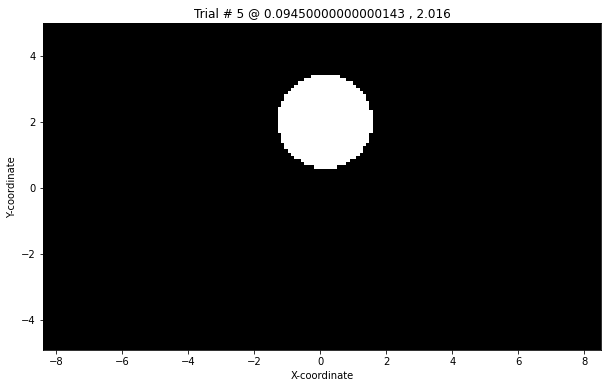

In [4]:
# check the stimulus masks by plotting a column of the stimulus mask as an
# image
tr_num=4 #plot trial - change a few times to spot-check
plt.figure(figsize=(10,16))
this_img = np.reshape(stim_mask[:,tr_num].T,(res[0],res[1]))
this_img=this_img.T #must transform because of how Python reshapes
tn='Trial # ' + str(tr_num+1) + ' @ ' + str(trn_conds[tr_num,0]) + ' , ' + str(trn_conds[tr_num,1])
plt.imshow(this_img,cmap='gray',origin='lower',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title(tn)

Spot-check a few trials - does everything look ok? Also try plotting a figure showing the visual field coverage - the extent of the screen subtended by *any* stimulus, across all trials. In this particular experiment, we randomized the position of each and every trial (relative to a fixed grid). This means that there will not necessarily be perfectly even coverage of the entire screen, but it does increase the number of unique stimulus positions we can use for encoding model estimation.

## Build encoding model
An encoding model describes how a neural unit responds to an arbitrary set of stimuli. A common encoding model for visual stimuli measured for decades is the spatial receptive field (RF). Rather than directly estimate the exact receptive field of each voxel, we'll instead suppose that there are a discrete number of possible RF positions (that is, a discrete number of spatial filters) which describe discrete neural subpopulations. Each voxel then can be modeled as a weighted sum of these discrete subpopulations. While this is of course an approximation of the actual nature of RF properties in the visual system, by supposing a small number of possible RF positions/subpopulations, we can *invert* the estimated encoding model (which is a set of weights on each supopulation for each voxel) in order to reconstruct the activation of each population given a novel voxel activation pattern observed (below). 

First, let's generate the filters corresponding to our hypothetical neural populations. We'll assume, for simplicity, that they are a square grid and are all the same "size" (FWHM). If interested, try varying these parameters. (See below for a hexagonal grid.) 

In [5]:
#make make2dcos function
def make2dcos(x,y,x_center,y_center,r,powr):
    # x, y is a meshgrid of x, y values at which to compute the 2d cos
    # x_center, y_center is the center of the function
    # r is the distance from center to 0 (T/2) - function will go from z = 0 to
    # 0 across 2*r at widest point
    # pow is power to which cosine function is raised
    z=np.zeros((x.shape[0],1))
    myr = ((x-x_center)**2+(y-y_center)**2)**0.5
    qq=myr<=r
    qq=qq*1
    indd=np.where(qq == 1)[0]
    zp=((0.5*(1 + np.cos(myr*np.pi/r) ))**powr)
    z=zp*qq
    return z

if hexsq==1:
    # Let's set the center points:
    rfPtsX = np.linspace(-4,4,9) * stim_size
    rfPtsY = np.linspace(-2,2,5) * stim_size
    rfGridX0,rfGridY0 = np.meshgrid(rfPtsX,rfPtsY)
    rfGridX = np.reshape(rfGridX0.T,(rfGridX0.size,1))
    rfGridY = np.reshape(rfGridY0.T,(rfGridY0.size,1))
    rfSize=1.25*stim_size # for the filter shape we use (see below), this size/spacing ratio works well (see Sprague & Serences, 2013)
    
    # because we're projecting a stimulus mask onto a lower-dimensional set of
    # filters, we call the set of filters (or information channels) our basis
    # set
    basis_set = np.zeros((xx.shape[0],rfGridX.shape[0])) # initialize - use zeros instead of nan

    for bb in range(rfGridX.shape[0]):
        # the form of the basis function Tommy uses is a gaussian-like blob which
        # reaches zero at a known distance from its center, which is 2.5166x
        # the FWHM of the function. We'll define the FWHM as rfSize (above),
        # which means the "size" parameter of our function is 2.5166*rfSize.

        result=make2dcos(xx,yy,rfGridX[bb],rfGridY[bb],rfSize*2.5166,7)
        basis_set[:,bb] = np.ndarray.flatten(result)

    #plot single
    plt.figure(figsize=(fs1,fs2))
    ii=0
    rs=np.reshape(basis_set[:,ii],(res[0],res[1]))
    plt.imshow(rs.T,cmap='jet',origin='lower',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Single')

    #plot all basis sets
    fig=plt.figure(figsize=(18,8))
    for ii in range(basis_set.shape[1]):
        plt.subplot(5,9,ii+1)
        rs=np.reshape(basis_set[:,ii],(res[0],res[1]))
        plt.imshow(rs.T,cmap='jet',origin='lower',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
    fig.text(0.5, 0.1, 'X-coordinate', ha='center')
    fig.text(0.1, 0.5, 'Y-coordinate', va='center', rotation='vertical')
    fig.suptitle('All, separately',fontsize=16)

    #plot all summed together 
    fig=plt.figure(figsize=(fs1,fs2))
    rs=np.reshape(np.sum(basis_set,axis=1),(res[0],res[1]))
    plt.imshow(rs.T,cmap='jet',origin='lower',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('All, summed together')

You can see that we've created a set of spatial RFs which span the space subtended by our mapping stimulus. Additionally, the second figure shows the "coverage" of the basis set, as well as the "smoothness" of its coverage over space. In our experience, this approximate ratio of FWHM:spacing for a square grid works well. A hexsqagonal grid of basis functions also works well, and in that case because the mean distance between each basis function is slightly smaller, the best FWHM:spacing ratio is also slightly smaller.
Above, you can try changing the size of each basis function by changing the "1" before "rfSize" in the call to make2dcos - try bigger and smaller basis function sizes. What are the advantages and disadvantages to each? Come back to this once you've reached the end of the tutorial and try processing the data w/ several basis function sizes. 

Larger bin = 8.0
Factor = 2.0
Rotation in radians = 1.0471975511965976
(17271, 37)


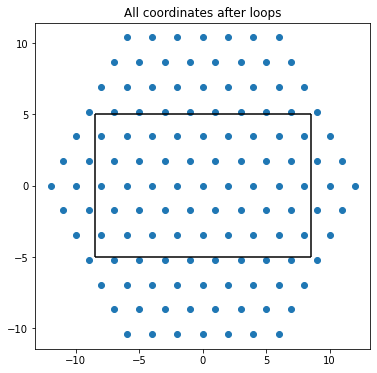

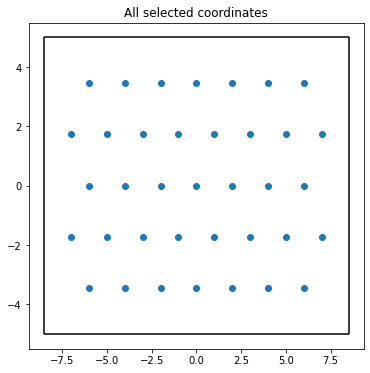

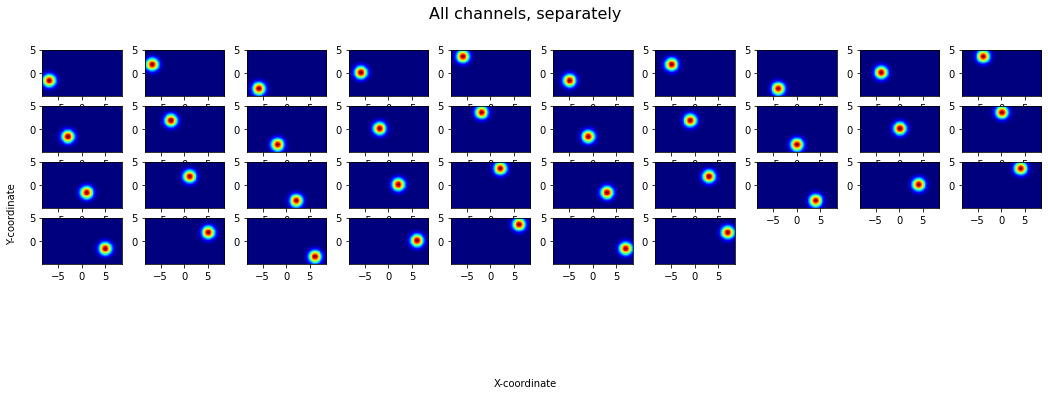

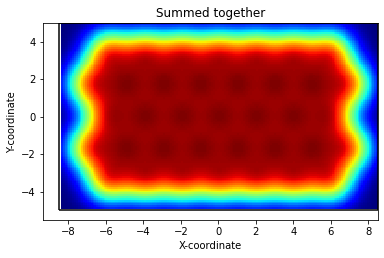

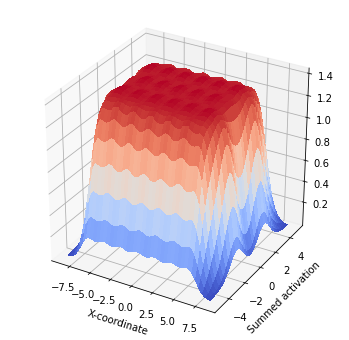

In [6]:
#the below follows all of the steps as above, but instead creates a hexagonal basis set
if hexsq==0:
    loops=6 # of loops from center you would like to create - affects density of basis sets
    bpad=0.5 #if you'd like to pad the edge at all
    eff_xb=xb-bpad #effective boundary
    eff_yb=yb-bpad
    largerb=np.max([eff_xb,eff_yb]) #choose whichever is greater for factor
    print('Larger bin = %s' %largerb)
    fact=(largerb*1.5)/loops #factor by which to size channel centers 
    stim_size=fact/2
    rfSize=2*stim_size #receptive field size 
    print('Factor = %s' %fact)
    symmetry=6 #for hexagonal
    rote=2*math.pi/symmetry #rotation angle (radians)
    print('Rotation in radians = %s' %rote)
    fup=1000 #this is just for pruning redundancies in the expansion
    coords=np.zeros((1,2))
    for loop in range(loops):
        iters=coords.shape[0]
        coordsN=np.zeros((iters*symmetry,2))
        #basically we go in every direction from every point, 
        #then prune overlapping points
        for i in range(iters): #loop through all iters
            for s in range(symmetry): #all symmetries
                coordsN[s+i*symmetry,0]=coords[i,0]+np.cos(s*rote)*fact
                coordsN[s+i*symmetry,1]=coords[i,1]+np.sin(s*rote)*fact
        coordsN=np.round(coordsN*fup)/fup
        coordsN=np.unique(coordsN,axis=0) #prune redundancies
        if loop==0:
            coords=np.vstack([coords,coordsN])
        else:
            coords=coordsN
    #create plot with ALL coordinates, before removing those outside the field of interest
    fig=plt.figure(figsize=(fs1,fs2))
    plt.scatter(coords[:,0],coords[:,1])
    plt.vlines((-xb,xb),-yb,yb)
    plt.hlines((-yb,yb),-xb,xb)
    plt.title('All coordinates after loops')

    #select only relevant coordinates
    fig=plt.figure(figsize=(fs1,fs2))
    ind=np.logical_and(np.logical_and(np.logical_and( 
        coords[:,0]<eff_xb,coords[:,0]>-eff_xb),coords[:,1]<eff_yb),coords[:,1]>-eff_yb)
    coords=coords[ind,:] #prune locations outside box
    plt.scatter(coords[:,0],coords[:,1])
    plt.vlines((-xb,xb),-yb,yb)
    plt.hlines((-yb,yb),-xb,xb)
    plt.title('All selected coordinates')

    basis_set = np.zeros((xx.shape[0],coords.shape[0])) # initialize - use zeros instead of nan
    for bb in range(coords.shape[0]):
        result=make2dcos(xx,yy,coords[bb,0],coords[bb,1],rfSize*2.25,5)
        #result=make2dcos(xx,yy,coords[bb,0],coords[bb,1],rfSize*2.5166,7)
        basis_set[:,bb] = np.ndarray.flatten(result)

    #plot some/all 
    print(basis_set.shape)
    fig=plt.figure(figsize=(18,6))
    for ii in range(basis_set.shape[1]):
        plt.subplot(6,10,ii+1)
        rs=np.reshape(basis_set[:,ii],(res[0],res[1]))
        plt.imshow(rs.T,cmap='jet',origin='lower',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
    fig.text(0.5, 0.1, 'X-coordinate', ha='center')
    fig.text(0.1, 0.5, 'Y-coordinate', va='center', rotation='vertical')
    fig.suptitle('All, separately',fontsize=16)

    #sum together
    fig=plt.figure(figsize=(fs1,fs2))
    rs=np.reshape(np.sum(basis_set,axis=1),(res[0],res[1]))
    plt.imshow(rs.T,cmap='jet',origin='lower',interpolation='none',
               extent=[x[1],x[-1],y[1],y[-1]],aspect='equal')
    plt.vlines((-xb,xb),-yb,yb)
    plt.hlines((-yb,yb),-xb,xb)
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Summed together')
    
    #surface plot, if of interest
    fig = plt.figure(figsize=(fs1,fs2))
    ax = fig.gca(projection='3d')
    rs=np.reshape(np.sum(basis_set,axis=1),(res[0],res[1]))
    surf = ax.plot_surface(xx2,yy2,rs.T, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.ylabel('Summed activation')

## Compute predicted channel responses
Now that we have a stimulus mask and a set of spatial filters/information channels, we want to determine the contribution of each information channel (hypothetical neural population) to each voxel. We set up the problem like a standard general linear model often used for fMRI
activation map-based analyses:

y = beta*X, 

where:
- y is the measured signal in a voxel across all trials (1 x n_trials)
- beta is the weights corresponding to how much each channel's response contributes to each voxel (stable across trials, 1 x n_channels)
- X is a design matrix, which is how much each hypothetical population, with its defined RF, should respond to the stimulus (which we know) (n_trials x n_channels)

Note that X is the same design matrix used for any standard GLM-based analysis in fMRI - we're just defining our "predictors" a bit differently. Here, predictors are predicted channel responses to known stimuli on each trial (the stimulus mask above). In order to compute the design matrix, we simply compute the overlap of the stimulus mask onto each channel. 

Text(0.5, 1.0, 'Sum - check for full rank and how much each channel is sampled')

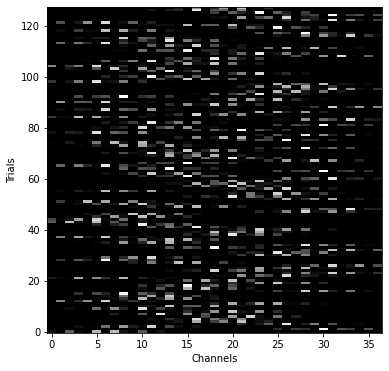

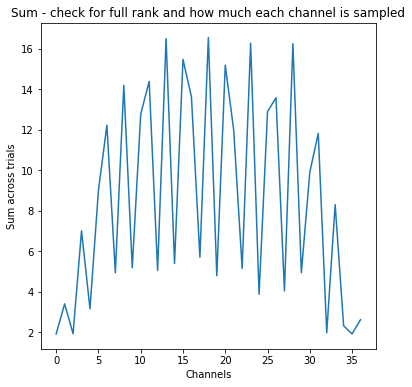

In [7]:
trnX=stim_mask.T.dot(basis_set) #JWA: these are the predicted responses
np.max(trnX)
trnX=trnX/np.max(trnX) #normalize to 1
plt.figure(figsize=(fs1,fs2))
plt.imshow(trnX,cmap='gray',origin='lower',interpolation='none',aspect='auto') #JWA: this is your design matrix
plt.xlabel('Channels')
plt.ylabel('Trials')
plt.figure(figsize=(fs1,fs2))
plt.plot(np.sum(trnX,axis=0))
plt.xlabel('Channels')
plt.ylabel('Sum across trials')
plt.title('Sum - check for full rank and how much each channel is sampled')

Now let's double-check our filtering by plotting the predicted channel responses for a given trial next to the stimulus mask for that trial.

Text(0, 0.5, 'Y-coordinate')

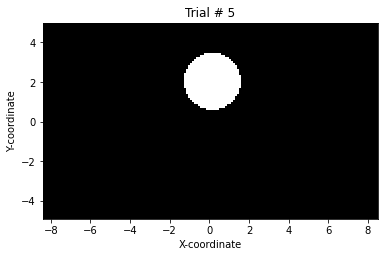

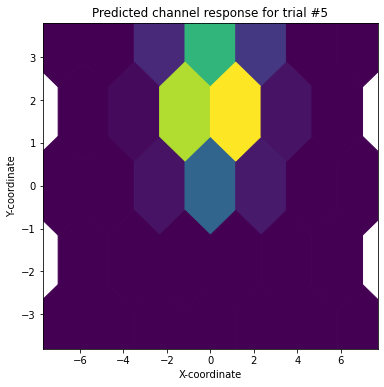

In [8]:
tr_num=4 #choose one trial
plt.figure(figsize=(fs1,fs2))
rs=np.reshape(stim_mask[:,tr_num],(res[0],res[1]))

plt.imshow(rs.T,cmap='gray',origin='lower',interpolation='none',
           extent=[x[1],x[-1],y[1],y[-1]],aspect='equal')
tn='Trial # ' + str(tr_num+1)
plt.title(tn)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

plt.figure(figsize=(fs1,fs2))
if hexsq==1: #square
    rs=np.reshape(trnX[tr_num,:],(len(rfPtsX),len(rfPtsY)))
    rs.shape
    plt.imshow(rs.T,cmap='gray',origin='lower',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
elif hexsq==0: #hex
    ind=coords[:,1]==0 #x coords = 0
    mxx=np.sum(ind)
    ind=coords[:,0]==0 #y coords = 0
    mxy=np.sum(ind)
    plt.hexbin(coords[:,0],coords[:,1],C=trnX[tr_num,:]*100,gridsize=(mxx-1,mxy-1))
tn='Predicted channel response for trial #5'
plt.title(tn)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

## Estimate channel weights using training data

Now that we have our design matrix and our measured signal, we need to solve for the weights ("betas" in above equation). Because we have more trials than channels, and because our stimulus positions are unique on each trial, we should be able to estimate a unique solution for the channel weights given our observed activation pattern using ordinary least squares regression. 

First, let's be sure our design matrix is "full-rank" (that is, that no predicted channel responses are colinear). This is always important to check, and could come about if you're using channels that are not uniquely sampled by the stimulus set. For example, if above you multiply the rfPtsX, rfPtsY vectors each by 3 before generating the design matrix, you would notice that many of the channels (those correspondign to the edges of the display) will always have "0" predicted activity. This means that it is impossible to estimate the contribution of such a channel to the activation of a voxel. This is also why we can only model the stimulated portion of the screen along model dimensions which we control.

As an example, V1 also has many orientation-selective populations (see IEM_ori_fMRI.ipynb), but we did not systematically vary the stimulus orientation here, and so we cannot uniquely estimate the contribution of different orientation-selective populations to the observed voxel activations in this dataset.

As a thought exercise, what are other scenarios (stimulus conditions or
hypothesized channel properties like size/position) which could result in
design matrices w/out full rank?

In [9]:
q=numpy.linalg.matrix_rank(trnX)
n='Rank of design matrix: ' + str(q) + ' / ' + str(trnX.shape[1])
print(n)
# So we've established that the design matrix is full-rank (the rank is
# equal to the number of columns). Let's estimate the channel weights.

w=numpy.linalg.pinv(trnX).dot(trn)
print('w is shape:')
print(w.shape)

Rank of design matrix: 37 / 37
w is shape:
(37, 653)


w is now n_channels x n_voxels. This step is massively univariate, and is identical to the step of estimating the beta weight corresponding to each predictor for each voxel in a standard fMRI GLM analysis. It's written above as a single matrix operation for brevity, but identical results are obtained when looping through individual voxels. 

## Invert the encoding model and compute channel responses

Our estimated "w" above reflects an ENCODING MODEL for each voxel. For a given region (here,  V1), we have an encoding model estimated for all voxels. Given our linear framework described above, we can INVERT the encoding model in order to estimate the channel activation pattern (like our trnX) which is associated with any novel activation pattern that is observed. The associated mapping from VOXEL SPACE into CHANNEL SPACE is computed from the pseudoinverse of the estimated weight matrix.

This inversion step is where we get "inverted" encoding model from - we're not just estimating encoding models for single voxels and comparing them; we're instead estimating all encoding models, and using the joint set of encoding models to constrain a mapping from voxel space into channel space. 

Once we have the inverted mapping (the pseudoinverse), we can map the novel activation pattern ("tst") back into channel space.

In [10]:
chan_resp=((np.linalg.inv(w.dot(w.T)).dot(w)).dot(tst.T)).T
print(chan_resp.shape)

(288, 37)


"chan_resp" is now the estimated channel responses for a novel dataset which was never used to estimate any encoding properties (that is, "tst" was never used in the computation of "w"). Each column of chan_resp corresponds to a channel, or hypothetical neural population response, and each row corresponds to a trial.
Let's see what the channel responses look like across different trial types. For now, let's just look at high-contrast stimuli presented on the right side of the screen on attend-stimulus trials. 
This means we'll search for trials with the following values in each of

# tst_conds' columns:
- column 1 (stimulus side, L or R):  1
- column 2 (stimulus contrast, 1-6): 6
- column 3 (task condition, attend fix or attend stim): 2
- column 4 (target present?): 0 (so that mean contrast is the same)

In [11]:
a = np.argwhere(tst_conds[:,0]==1);b = np.argwhere(tst_conds[:,1]==6)
c = np.argwhere(tst_conds[:,2]==2);d = np.argwhere(tst_conds[:,3]==0)
ab = np.intersect1d(a,b);abc=np.intersect1d(ab,c)
thisidx=np.intersect1d(abc,d)
avg_chan_resp=np.mean(chan_resp[thisidx,:],axis=0)

a = np.argwhere(tst_conds[:,0]==2);b = np.argwhere(tst_conds[:,1]==6)
c = np.argwhere(tst_conds[:,2]==2);d = np.argwhere(tst_conds[:,3]==0)
ab = np.intersect1d(a,b);abc=np.intersect1d(ab,c)
thisidx2=np.intersect1d(abc,d)
avg_chan_resp2=np.mean(chan_resp[thisidx2,:],axis=0)

both=np.concatenate((avg_chan_resp,avg_chan_resp2))
gmin=np.min(both);gmax=np.max(both) #find grand min and max
print(avg_chan_resp.shape)

(37,)


Text(0, 0.5, 'Y-coordinate')

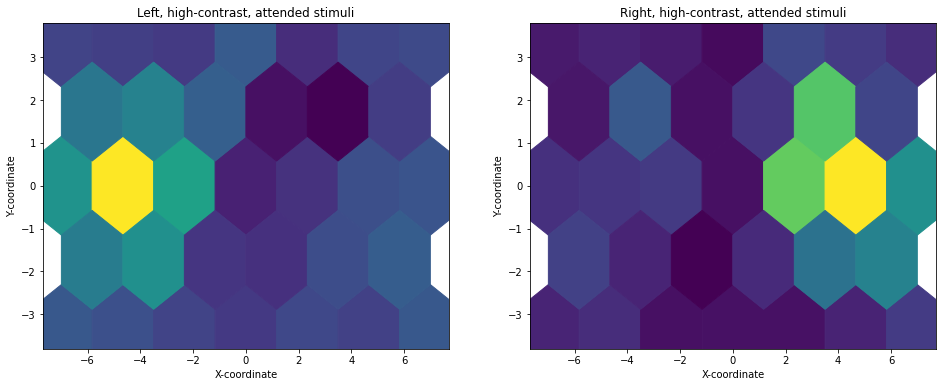

In [12]:
plt.figure(figsize=(16,6))
plt.subplot(121)
if hexsq==1: #square
    rs=np.reshape(avg_chan_resp,(len(rfPtsX),len(rfPtsY)))
    plt.imshow(rs.T,vmin=gmin,vmax=gmax,origin='lower',cmap='jet',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
elif hexsq==0: #hexsq
    plt.hexbin(coords[:,0],coords[:,1],C=avg_chan_resp*100,gridsize=(mxx-1,mxy-1))

tn='Left, high-contrast, attended stimuli'
plt.title(tn)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

# now compare to trials when the stimulus was on the right
plt.subplot(122)
if hexsq==1: #square
    rs2=np.reshape(avg_chan_resp2,(len(rfPtsX),len(rfPtsY)))
    plt.imshow(rs2.T,vmin=gmin,vmax=gmax,origin='lower',cmap='jet',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
elif hexsq==0: #hexsq
    plt.hexbin(coords[:,0],coords[:,1],C=avg_chan_resp2*100,gridsize=(mxx-1,mxy-1))

tn='Right, high-contrast, attended stimuli'
plt.title(tn)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
# importantly, we want to be sure all the axes are on the same color-scale.

# It should be clear that the channels with RFs near the attended stimulus
# position are those which are most active when that sitmulus is present &
# attended.

In [13]:
#JWA: to graph all conditions, need to find grand min and max for consistent axes
attn_conds=2;stim_contrasts=6
gmin=np.zeros((attn_conds*stim_contrasts))
gmax=np.zeros((attn_conds*stim_contrasts))
for stim_side in range(2):
    for attn_cond in range(2):
        for stim_contrast in range(6):
            gnum=(attn_cond+1)+stim_contrast*2
            a = np.argwhere(tst_conds[:,0]==stim_side+1);b = np.argwhere(tst_conds[:,1]==stim_contrast+1)
            c = np.argwhere(tst_conds[:,2]==attn_cond+1);d = np.argwhere(tst_conds[:,3]==0)
            ab = np.intersect1d(a,b);abc=np.intersect1d(ab,c);thisidx=np.intersect1d(abc,d)
            avg_chan_resp=np.mean(chan_resp[thisidx,:],axis=0)      

            gmin[gnum-1]=np.min(avg_chan_resp)
            gmax[gnum-1]=np.max(avg_chan_resp)
        
ggmin=np.min(gmin)
ggmax=np.max(gmax)    
print(ggmin)
print(ggmax)

-0.17925502802379267
0.6527673173376065


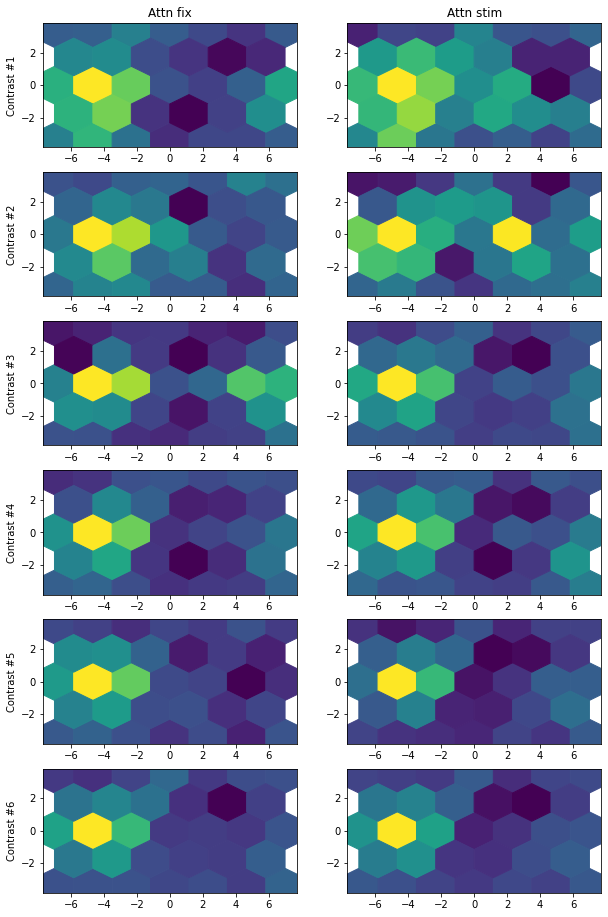

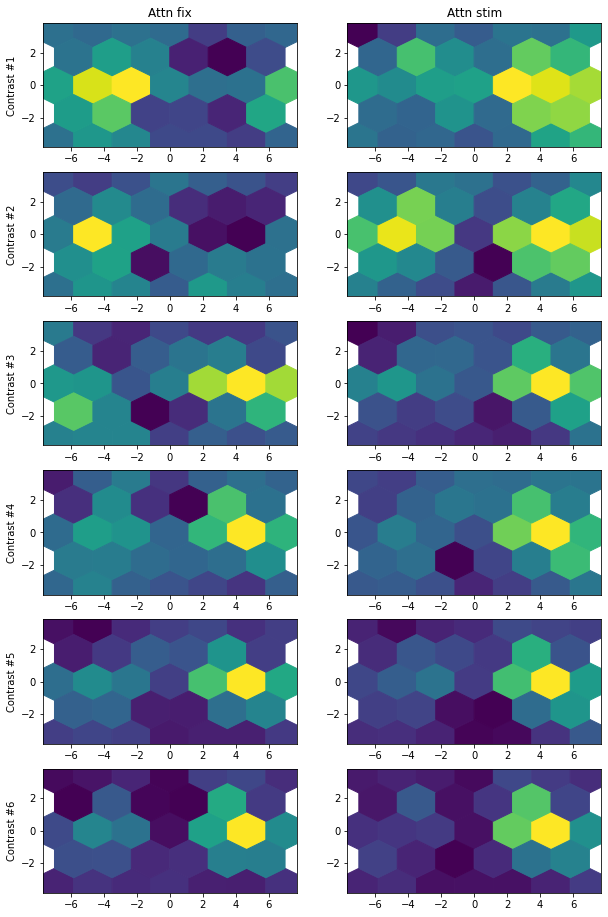

In [14]:
plt.figure(1,figsize=(10,16))
plt.figure(2,figsize=(10,16))
for stim_side in range(2):
    plt.figure(stim_side+1)
    for attn_cond in range(2):
        for stim_contrast in range(6):
            gnum=(attn_cond+1)+stim_contrast*2
            plt.subplot(6,2,gnum)
            a = np.argwhere(tst_conds[:,0]==stim_side+1);b = np.argwhere(tst_conds[:,1]==stim_contrast+1)
            c = np.argwhere(tst_conds[:,2]==attn_cond+1);d = np.argwhere(tst_conds[:,3]==0)
            ab = np.intersect1d(a,b);abc=np.intersect1d(ab,c);thisidx=np.intersect1d(abc,d)
            avg_chan_resp=np.mean(chan_resp[thisidx,:],axis=0)
            if hexsq==1: #square
                rs=np.reshape(avg_chan_resp,(len(rfPtsX),len(rfPtsY)))
                plt.imshow(rs.T,vmin=ggmin,vmax=ggmax,origin='lower',cmap='jet',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
            elif hexsq==0: #hexsq
                #right now, I'm not using the global min/max here since it was being buggy
                plt.hexbin(coords[:,0],coords[:,1],C=avg_chan_resp*100,gridsize=(mxx-1,mxy-1))

            if stim_contrast==0:
                if attn_cond==0:
                    plt.title('Attn fix')
                elif attn_cond==1:
                    plt.title('Attn stim')
            
            if attn_cond==0:
                tn='Contrast #' + str(stim_contrast+1)
                plt.ylabel(tn)        

## Compute stimulus reconstructions from channel responses
The channel response plots above are the *full* dataset, though sometimes it is useful to compute a stimulus reconstruction that can be more easily quantified (e.g. by curvefitting methods). Furthermore, the discrete values above are challenging to "coregister" across different stimulus position conditions (at least when stimuli are not simply at the same position on different sides of the screen). Take for example a scenario like Sprague, Ester & Serences, 2014 - during a spatial WM task, a remembered stimulus appeared at a random position along a ring of a given eccentricity. Because we were not interested in whether or not representations for stimuli at different positions were different from one another, we sought to average representations for stimuli at different positions together. We did this by reconstructing an "image" of the contents of WM via a weighted sum of the spatial filters for each channel. Let's try that here.

We have our basis_set, used to compute predicted channel responses, and we have our estimated channel responses (chan_resp) - to compute the weighted sum as an image, we just need to multiply the two.

In [15]:
stim_reconstructions=chan_resp.dot(basis_set.T)

Importantly, the dimensionality of each reconstruction remains equal to the number of channels used, but this enables easy averaging of stimuli at different positions (say, around a circular ring) by changing the basis set in order to "undo" the stimulus manipulation performed. See Sprague, Ester & Serences, 2014, for more details (Fig 2E). We won't go over that here. This discussion is mainly to illustrate that we gain no information in going from channel responses to stimulus reconstructions, but the added ability to coregister and average different stimuli affords better sensitivity to low-amplitude/low-SNR representations in stimulus reconstructions. 

We can now do all the analyses we performed above on channel response amplitudes instead on stimulus reconstructions. For example:

In [16]:
a = np.argwhere(tst_conds[:,0]==1);b = np.argwhere(tst_conds[:,1]==6)
c = np.argwhere(tst_conds[:,2]==2);d = np.argwhere(tst_conds[:,3]==0)
ab = np.intersect1d(a,b);abc=np.intersect1d(ab,c)
thisidx=np.intersect1d(abc,d)
avg_reconstruction=np.mean(stim_reconstructions[thisidx,:],axis=0)
a = np.argwhere(tst_conds[:,0]==2);b = np.argwhere(tst_conds[:,1]==6)
c = np.argwhere(tst_conds[:,2]==2);d = np.argwhere(tst_conds[:,3]==0)
ab = np.intersect1d(a,b);abc=np.intersect1d(ab,c)
thisidx2=np.intersect1d(abc,d)
avg_reconstruction2=np.mean(stim_reconstructions[thisidx2,:],axis=0)
both=np.concatenate((avg_reconstruction,avg_reconstruction2))
gmin=np.min(both);gmax=np.max(both)
print('Shape of reconstruction space: %s' %avg_reconstruction.shape)

Shape of reconstruction space: 17271


Text(0, 0.5, 'Y-coordinate')

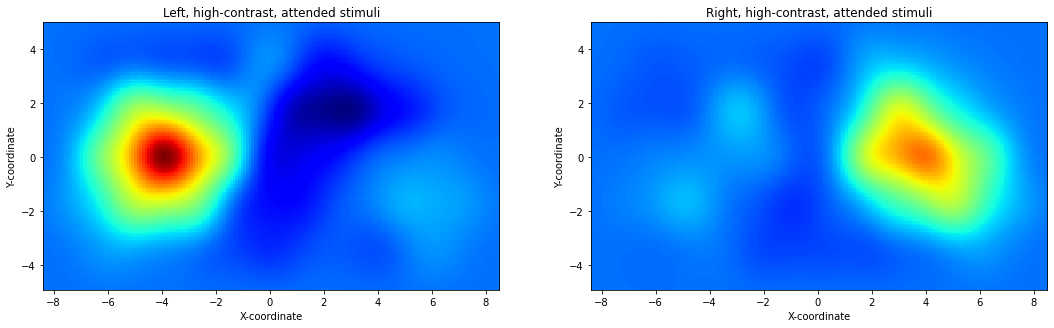

In [17]:
plt.figure(figsize=(18,16))
plt.subplot(121)
rs=np.reshape(avg_reconstruction,(res[0],res[1]))
plt.imshow(rs.T,vmin=gmin, vmax=gmax,origin='lower',cmap='jet',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
tn='Left, high-contrast, attended stimuli'
plt.title(tn)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

# now compare to trials when the stimulus was on the right
plt.subplot(122)
rs2=np.reshape(avg_reconstruction2,(res[0],res[1]))
plt.imshow(rs2.T,vmin=gmin,vmax=gmax,origin='lower',cmap='jet',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
tn='Right, high-contrast, attended stimuli'
plt.title(tn)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')

## Combine non-like stimulus feature values

One of the biggest advantages of the IEM technique is that by transforming activation patterns into a "feature space" (here, spatial information channels), you have full knowledge of how your activation is related to feature values. Put another way, you know how to manipulate your feature space in order to coregister non-like trials. For example, here, we don't necessarily care too much about what may or may not be different in stimulus reconstructions computed from trials in which stimuli were on the left compared with trials when stimuli were on the right. 

Accordingly, we can average these trials after "coregistering" the reconstructions. Fortunately, this is an easy dataset to coregister. We just need to flip the reconstructions across the vertical meridian for one half of trials [sorted by trn_conds[:,1], which is the stimulus side]. It doesn't matter whether we flip left trials onto the right side of the screen or vice versa. Try it below!

So that it's easy to "flip" the reconstructions, let's turn our reconstruction matrix, in which each reconstruction occupies a row (n_trials x n_pixels), into a reconstruction 3d-matrix in which each trial is the 3rd dimension, and each "slice" is a single-trial's stimulus reconstruction. It's easiest to make trial the 3rd dimension so that we don't need to "squeeze" the data later on.

In [18]:
stim_reconstructions_mat=np.empty((stim_reconstructions.shape[0],res[0],res[1]))

# now, look for all trials with tst_cond(:,1)==1 and "coregister" them by 
# flipping the slice of the matrix across the vertical axis
a=np.argwhere(tst_conds[:,0]==1)

for i in range(stim_reconstructions.shape[0]):
    q=np.reshape(stim_reconstructions[i,:],(res[0],res[1]))
    if tst_conds[i,0]==1:
        #flip x axis ... 
        q=q.T
        q=np.fliplr(q)
        q=q.T
    stim_reconstructions_mat[i,:,:]=q

attn_cond=0;stim_contrast=0
a = np.argwhere(tst_conds[:,1]==stim_contrast+1);b = np.argwhere(tst_conds[:,2]==attn_cond+1)
c = np.argwhere(tst_conds[:,3]==0);ab = np.intersect1d(a,b);thisidx=np.intersect1d(ab,c)

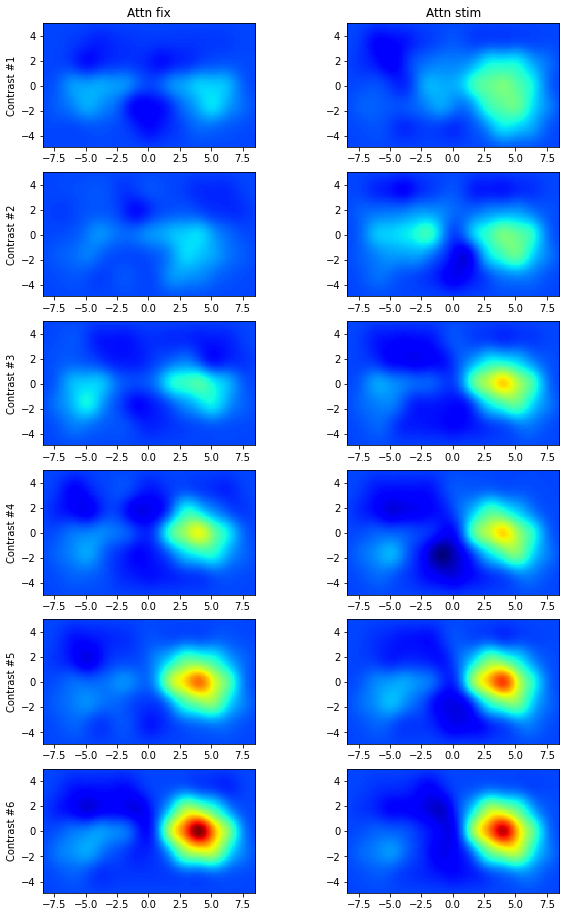

In [19]:
# now we can plot a figure with all trials on the same plot.
#JWA: first, we must find the global min and max
gmin=np.zeros((attn_conds*stim_contrasts))
gmax=np.zeros((attn_conds*stim_contrasts))
for attn_cond in range(attn_conds):
    for stim_contrast in range(stim_contrasts):
        gnum=(attn_cond+1)+stim_contrast*2
        a = np.argwhere(tst_conds[:,1]==stim_contrast+1);b = np.argwhere(tst_conds[:,2]==attn_cond+1)
        c = np.argwhere(tst_conds[:,3]==0);ab = np.intersect1d(a,b);thisidx=np.intersect1d(ab,c)
        #rs=np.mean(stim_reconstructions_mat[:,:,thisidx],axis=2)
        rs=np.mean(stim_reconstructions_mat[thisidx,:,:],axis=0)
        
        gmin[gnum-1]=np.min(rs)
        gmax[gnum-1]=np.max(rs)
        
ggmin=np.min(gmin)
ggmax=np.max(gmax)

plt.figure(figsize=(10,16))
for attn_cond in range(attn_conds):
    for stim_contrast in range(stim_contrasts):
        gnum=(attn_cond+1)+stim_contrast*2
        plt.subplot(6,2,gnum)
        a = np.argwhere(tst_conds[:,1]==stim_contrast+1);b = np.argwhere(tst_conds[:,2]==attn_cond+1)
        c = np.argwhere(tst_conds[:,3]==0);ab = np.intersect1d(a,b);thisidx=np.intersect1d(ab,c)
        rs=np.mean(stim_reconstructions_mat[thisidx,:,:],axis=0)
        
        plt.imshow(rs.T,vmin=ggmin,vmax=ggmax,origin='lower',cmap='jet',interpolation='none',extent=[x[1],x[-1],y[1],y[-1]])
        if stim_contrast==0:
            if attn_cond==0:
                plt.title('Attn fix')
            elif attn_cond==1:
                plt.title('Attn stim')
            
        if attn_cond==0:
            tn='Contrast #' + str(stim_contrast+1)
            plt.ylabel(tn)

In [20]:
#JWA: in case one desires a generic function to train + reconstruct all at once
def IEM_train_test(trnX,trn,basis_set):
    print('GLM design matrix is shape:')
    print(trnX.shape)
    rank=numpy.linalg.matrix_rank(trnX)
    n='Rank of design matrix: ' + str(rank) + ' / ' + str(trnX.shape[1])
    print(n)
    if rank==trnX.shape[1]:
        print('This is full rank!')
    elif rank==trnX.shape[1]:
        print('WARNING: This is not full rank!')
    w=numpy.linalg.pinv(trnX).dot(trn)
    print('w is shape:')
    print(w.shape)
    chan_resp=((np.linalg.inv(w.dot(w.T)).dot(w)).dot(tst.T)).T
    print('chan_resp is shape:')
    print(chan_resp.shape)
    stim_reconstructions=chan_resp.dot(basis_set.T)
    return w,chan_resp,stim_reconstructions

In [21]:
w,chan_resp,stim_reconstructions=IEM_train_test(trnX,trn,basis_set) #run

GLM design matrix is shape:
(128, 37)
Rank of design matrix: 37 / 37
This is full rank!
w is shape:
(37, 653)
chan_resp is shape:
(288, 37)
